In [1]:
try:
    from pyspark import SparkContext, SparkConf
    from pyspark.sql import SparkSession
except ImportError as e:
    print('<<<<<!!!!! Please restart your kernel after installing Apache Spark !!!!!>>>>>')
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

In [14]:
from sklearn.datasets import make_moons, make_circles, make_blobs
import matplotlib.pyplot as plt

HELLO


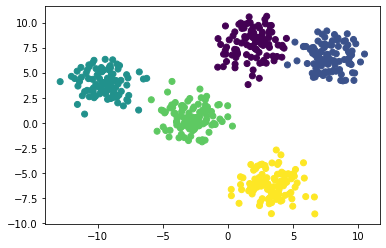

In [74]:
X, Y = make_blobs(n_samples=500, n_features=2, centers = 5, center_box=(-10, 10), random_state=20, cluster_std=1.3)
print('HELLO')
plt.scatter(X[:, 0], X[:, 1], c=Y)

In [111]:
def data_to_fully_connected_graph(df, cut=False):
    va = VectorAssembler(inputCols=df.columns, outputCol="vec1")
    df_vec = va.transform(df).drop(*df.columns).withColumn('src', row_number()
                                                           .over(Window.orderBy(monotonically_increasing_id())))
    df_pairs = df_vec.join(df_vec.toDF('vec2', 'dst')).filter("src < dst")
    udffunc = udf(distance.euclidean, FloatType())
    df_final = df_pairs.withColumn("weight",udffunc("vec1", "vec2")).drop('vec1', 'vec2')
    if cut:
        eps = df_final.groupBy('src').min('weight').agg({'min(weight)': 'max'}).collect()[0][0]
        return df_final.filter(df_final.weight < eps)
    else:
        return df_final


def CustomPIC(X, eps = 0.1, k = 2, maxIter=20, initMode="degree", cut=False):
    df = sc.parallelize(X).map(lambda x: [float(i) for i in x]).toDF(["A", "B"])
    graph = data_to_fully_connected_graph(df, cut)

    pic = PowerIterationClustering(k=k, maxIter=maxIter, initMode=initMode, weightCol="weight")
#     clustered_df = pic.assignClusters(graph.filter(graph.weight < eps))
    clustered_df = pic.assignClusters(graph)

    va = VectorAssembler(inputCols=df.columns, outputCol="features")

    df_vec = va.transform(df).withColumn('id', row_number().over(Window.orderBy(monotonically_increasing_id())))

    return df_vec.join(clustered_df, on='id', how='outer').fillna(-1)

In [13]:
from sklearn.datasets import make_moons, make_circles
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf,col
from pyspark.sql.types import *
from pyspark.ml.feature import Interaction, VectorAssembler
from pyspark.sql.functions import desc, row_number, monotonically_increasing_id
from pyspark.sql.window import Window
from scipy.spatial import distance
from pyspark.ml.clustering import PowerIterationClustering

X, Y = make_blobs(n_samples=500, n_features=2, centers = 5, center_box=(-10, 10), random_state=20, cluster_std=1.3)
import time

start_time = time.time()

df_vec = CustomPIC(X, k=5, initMode="degree", maxIter=50)
res = df_vec.toPandas()

print(time.time() - start_time)
plt.scatter(res['A'], res['B'], c=res['cluster'])

NameError: name 'make_blobs' is not defined

In [102]:
res['cluster'].value_counts()

0    182
2    118
4    107
1     65
3     28
Name: cluster, dtype: int64

In [103]:
evaluator = ClusteringEvaluator(predictionCol='cluster')
silhouette = evaluator.evaluate(df_vec)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.6033491748466082


72.9784049987793


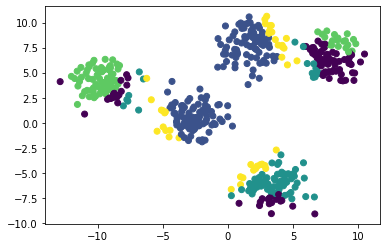

In [104]:
start_time = time.time()

df_vec = CustomPIC(X, eps=0, k=5, initMode="degree", maxIter=50, cut=True)
res = df_vec.toPandas()

print(time.time()-start_time)

plt.scatter(res['A'], res['B'], c=res['cluster'])

In [105]:
res['cluster'].value_counts()

1    174
0    102
3     93
2     89
4     42
Name: cluster, dtype: int64

In [106]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator(predictionCol='cluster')
silhouette = evaluator.evaluate(df_vec)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.1440395063673405


In [107]:
res['cluster'].value_counts()

1    174
0    102
3     93
2     89
4     42
Name: cluster, dtype: int64

In [73]:
df = spark.createDataFrame([
    (0, 1, 0.4),
    (0, 2, 0.5),
    (1, 2, 0.6),
    (3, 4, 0.7),
    (4, 0, 0.8)
], ["src", "dst", "weight"])

In [49]:
eps = 0.6
df.filter(df.weight < eps).show()

+---+---+------+
|src|dst|weight|
+---+---+------+
|  0|  1|   0.4|
|  0|  2|   0.5|
+---+---+------+



In [79]:
def data_to_fully_connected_graph(df, dist_func):
    va = VectorAssembler(inputCols=df.columns, outputCol="vec1")
    df_vec = va.transform(df).drop(*df.columns).withColumn('src', row_number()
                                                           .over(Window.orderBy(monotonically_increasing_id())))
    df_pairs = df_vec.join(df_vec.toDF('vec2', 'dst')).filter("src < dst")
    udffunc = udf(dist_func, FloatType())
    df_final = df_pairs.withColumn("weight",udffunc("vec1", "vec2")).drop('vec1', 'vec2')
    return df_final


def CustomPIC(X, k = 2, maxIter=20, initMode="degree"):
    df = sc.parallelize(X).map(lambda x: [float(i) for i in x]).toDF(["A", "B"])
    graph = data_to_fully_connected_graph(df, distance.euclidean)

    pic = PowerIterationClustering(k=k, maxIter=maxIter, initMode=initMode, weightCol="weight")

    clustered_df = pic.assignClusters(graph)

    va = VectorAssembler(inputCols=df.columns, outputCol="features")

    df_vec = va.transform(df).withColumn('id', row_number().over(Window.orderBy(monotonically_increasing_id())))

    return df_vec.join(clustered_df, on='id', how='outer').fillna(-1)

1622138541.1106508

In [168]:
class CustomPIC:
    def __init__(self, predictionCol='labels', dist_func=distance.euclidean, **configuration):
        self.algorithm = PowerIterationClustering(**configuration)
        self.predictionCol = predictionCol
        self.dist_func = dist_func
        
    def fit(self, data):
        udffunc = udf(self.dist_func, FloatType())
        res = data.select('features')\
                  .withColumn('src', row_number().over(Window.orderBy(monotonically_increasing_id())))
        res = res.join(res.toDF('features2', 'dst'))\
                 .filter("src < dst")\
                 .withColumn("weight",udffunc("features", "features2"))\
                 .drop('features', 'features2')
        clustered_df = self.algorithm.assignClusters(res)
        return self

custom_pic = CustomPIC(predictionCol='labels', k=5, maxIter=16)

custom_pic = custom_pic.fit(df_dreifi)

Exception ignored in: <function JavaWrapper.__del__ at 0x0000029FAFC86B88>
Traceback (most recent call last):
  File "C:\Users\Vladimir\anaconda3\envs\spark_env\lib\site-packages\pyspark\ml\wrapper.py", line 42, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'PowerIterationClustering' object has no attribute '_java_obj'


Py4JJavaError: An error occurred while calling o3808.assignClusters.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 100960.0 failed 1 times, most recent failure: Lost task 0.0 in stage 100960.0 (TID 17354, LAPTOP-O833454O, executor driver): java.lang.OutOfMemoryError: Java heap space
	at scala.LowPriorityImplicits.wrapRefArray(Predef.scala:614)
	at org.apache.spark.mllib.clustering.PowerIterationClustering$.$anonfun$normalize$4(PowerIterationClustering.scala:290)
	at org.apache.spark.mllib.clustering.PowerIterationClustering$$$Lambda$2665/0x00000001012a6040.apply(Unknown Source)
	at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:484)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:490)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1429)
	at org.apache.spark.graphx.EdgeRDD$.$anonfun$fromEdges$1(EdgeRDD.scala:107)
	at org.apache.spark.graphx.EdgeRDD$.$anonfun$fromEdges$1$adapted(EdgeRDD.scala:105)
	at org.apache.spark.graphx.EdgeRDD$$$Lambda$2667/0x00000001012ac840.apply(Unknown Source)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndex$2(RDD.scala:889)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndex$2$adapted(RDD.scala:889)
	at org.apache.spark.rdd.RDD$$Lambda$2506/0x00000001011ca440.apply(Unknown Source)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.$anonfun$getOrCompute$1(RDD.scala:362)
	at org.apache.spark.rdd.RDD$$Lambda$2671/0x00000001012b8840.apply(Unknown Source)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1371)
	at org.apache.spark.storage.BlockManager$$Lambda$1052/0x000000010085a040.apply(Unknown Source)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1298)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1362)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1186)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:360)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:311)
	at org.apache.spark.graphx.EdgeRDD.compute(EdgeRDD.scala:50)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2023)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:1972)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:1971)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1971)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:950)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:950)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:950)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2203)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2152)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2141)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:752)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2093)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2114)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2133)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2158)
	at org.apache.spark.rdd.RDD.$anonfun$foreachPartition$1(RDD.scala:994)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.RDD.foreachPartition(RDD.scala:992)
	at org.apache.spark.mllib.clustering.PowerIterationClustering$.materialize(PowerIterationClustering.scala:448)
	at org.apache.spark.mllib.clustering.PowerIterationClustering$.normalize(PowerIterationClustering.scala:307)
	at org.apache.spark.mllib.clustering.PowerIterationClustering.run(PowerIterationClustering.scala:205)
	at org.apache.spark.ml.clustering.PowerIterationClustering.assignClusters(PowerIterationClustering.scala:183)
	at jdk.internal.reflect.GeneratedMethodAccessor188.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: java.lang.OutOfMemoryError: Java heap space
	at scala.LowPriorityImplicits.wrapRefArray(Predef.scala:614)
	at org.apache.spark.mllib.clustering.PowerIterationClustering$.$anonfun$normalize$4(PowerIterationClustering.scala:290)
	at org.apache.spark.mllib.clustering.PowerIterationClustering$$$Lambda$2665/0x00000001012a6040.apply(Unknown Source)
	at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:484)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:490)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1429)
	at org.apache.spark.graphx.EdgeRDD$.$anonfun$fromEdges$1(EdgeRDD.scala:107)
	at org.apache.spark.graphx.EdgeRDD$.$anonfun$fromEdges$1$adapted(EdgeRDD.scala:105)
	at org.apache.spark.graphx.EdgeRDD$$$Lambda$2667/0x00000001012ac840.apply(Unknown Source)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndex$2(RDD.scala:889)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndex$2$adapted(RDD.scala:889)
	at org.apache.spark.rdd.RDD$$Lambda$2506/0x00000001011ca440.apply(Unknown Source)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.$anonfun$getOrCompute$1(RDD.scala:362)
	at org.apache.spark.rdd.RDD$$Lambda$2671/0x00000001012b8840.apply(Unknown Source)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1371)
	at org.apache.spark.storage.BlockManager$$Lambda$1052/0x000000010085a040.apply(Unknown Source)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1298)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1362)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1186)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:360)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:311)
	at org.apache.spark.graphx.EdgeRDD.compute(EdgeRDD.scala:50)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)


----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 57332)
Traceback (most recent call last):
  File "C:\Users\Vladimir\anaconda3\envs\spark_env\lib\socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "C:\Users\Vladimir\anaconda3\envs\spark_env\lib\socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "C:\Users\Vladimir\anaconda3\envs\spark_env\lib\socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "C:\Users\Vladimir\anaconda3\envs\spark_env\lib\socketserver.py", line 720, in __init__
    self.handle()
  File "C:\Users\Vladimir\anaconda3\envs\spark_env\lib\site-packages\pyspark\accumulators.py", line 268, in handle
    poll(accum_updates)
  File "C:\Users\Vladimir\anaconda3\envs\spark_env\lib\site-packages\pyspark\accumulators.py", line 241, in poll
    if func()

In [158]:
res = df_dreifi.select('features').withColumn('src', row_number().over(Window.orderBy(monotonically_increasing_id())))
res = res.join(res.toDF('features2', 'dst')).filter("src < dst")
dist_func = distance.euclidean
udffunc = udf(dist_func, FloatType())
res= res.withColumn("weight",udffunc("features", "features2")).drop('features', 'features2')
res.show()

+---+---+---------+
|src|dst|   weight|
+---+---+---------+
|  1|  2|6.3064957|
|  1|  3| 5.315432|
|  1|  4| 6.184653|
|  1|  5|2.4406922|
|  1|  6|6.6402407|
|  1|  7| 4.427399|
|  1|  8|  6.26481|
|  1|  9|6.2348566|
|  1| 10| 5.875138|
|  1| 11|6.4756265|
|  1| 12| 4.179731|
|  1| 13| 2.376219|
|  1| 14| 5.141484|
|  1| 15|1.3150163|
|  1| 16|7.3816357|
|  1| 17|6.6599126|
|  1| 18|3.9761775|
|  1| 19| 5.027585|
|  1| 20|4.4351144|
|  1| 21|3.8754997|
+---+---+---------+
only showing top 20 rows



In [137]:
df_dreifi.select('features')

DataFrame[features: vector]

In [8]:
import pandas as pd
df = pd.read_csv('./datasets/1526IE10_002_PoDreifam.txt', sep=' ', skiprows=[0], header=None, index_col=0)

In [9]:
from utils import pandas_to_spark, preprocess

In [10]:
df.rename(columns={col:str(col) for col in df.columns}, inplace=True)
df_dreifi = preprocess(pandas_to_spark(sc, df))

In [159]:
df_dreifi.select('features').head()

Row(features=SparseVector(205, {20: 2.9375, 21: 2.9, 22: 2.925, 23: 2.9375, 24: 2.95, 25: 2.95, 26: 2.95, 27: 3.0625, 38: -9.84, 39: -9.82, 40: -9.82, 41: -9.9, 42: -10.34, 43: -10.02, 44: -10.02, 45: -10.0, 56: 49.9, 57: 49.9, 58: 49.9, 59: 49.9, 60: 49.9, 61: 49.9, 62: 49.9, 63: 49.9, 74: 50.0, 75: 49.9, 76: 49.9, 77: 49.9, 78: 49.9, 79: 49.9, 80: 49.9, 81: 49.9, 83: 0.15, 84: 0.15, 85: 0.15, 86: 0.15, 87: 0.15, 88: 0.15, 89: 0.2, 90: 0.15, 102: 0.0333, 105: 0.0333, 106: 0.0333}))

In [141]:
df

,1,2,3,4,5,6,7,8,9,10,...,196,197,198,199,200,201,202,203,204,205
0,,,,,,,,,,,,,,,,,,,,,
4586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4587,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4589,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
df_ = spark.createDataFrame([
    (0, 1, 0.4),
    (0, 2, 0.5),
    (1, 2, 0.6),
    (3, 4, 0.7),
    (4, 0, 0.8)
], ["src", "dst", "weight"])

In [4]:
df_.show()

+---+---+------+
|src|dst|weight|
+---+---+------+
|  0|  1|   0.4|
|  0|  2|   0.5|
|  1|  2|   0.6|
|  3|  4|   0.7|
|  4|  0|   0.8|
+---+---+------+



In [6]:
df_.withColumnRenamed('src', 'src1').crossJoin(df_.withColumnRenamed('src', 'src1')).show()

+----+---+------+----+---+------+
|src1|dst|weight|src1|dst|weight|
+----+---+------+----+---+------+
|   0|  1|   0.4|   0|  1|   0.4|
|   0|  1|   0.4|   0|  2|   0.5|
|   0|  1|   0.4|   1|  2|   0.6|
|   0|  1|   0.4|   3|  4|   0.7|
|   0|  1|   0.4|   4|  0|   0.8|
|   0|  2|   0.5|   0|  1|   0.4|
|   0|  2|   0.5|   0|  2|   0.5|
|   0|  2|   0.5|   1|  2|   0.6|
|   0|  2|   0.5|   3|  4|   0.7|
|   0|  2|   0.5|   4|  0|   0.8|
|   1|  2|   0.6|   0|  1|   0.4|
|   1|  2|   0.6|   0|  2|   0.5|
|   1|  2|   0.6|   1|  2|   0.6|
|   1|  2|   0.6|   3|  4|   0.7|
|   1|  2|   0.6|   4|  0|   0.8|
|   3|  4|   0.7|   0|  1|   0.4|
|   3|  4|   0.7|   0|  2|   0.5|
|   3|  4|   0.7|   1|  2|   0.6|
|   3|  4|   0.7|   3|  4|   0.7|
|   3|  4|   0.7|   4|  0|   0.8|
+----+---+------+----+---+------+
only showing top 20 rows



In [21]:
f_s = df_dreifi.select("features").withColumn('src', row_number().over(Window.orderBy(monotonically_increasing_id())))
udffunc = udf(distance.euclidean, FloatType())
res = f_s.crossJoin(f_s.toDF('features2', 'dst')).filter("src<dst").withColumn("weight",udffunc("features", "features2")).drop('features', 'features2')

In [ ]:
from pyspark.sql.functions import mean
res.select(mean(col('weight')).alias('mean')).show()